In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm
from script import *
import itertools

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
plt.rc('figure', figsize=(18.0, 6.0))

In [4]:
pd.set_option('display.max_columns', None) 

In [5]:
df = load_building(4874, '2016-10-01 00:00:00', '2016-10-31 00:00:00')

In [104]:
df_weather_austin = load_weather('austin')

## ARIMA model

### Explore model

In [6]:
import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

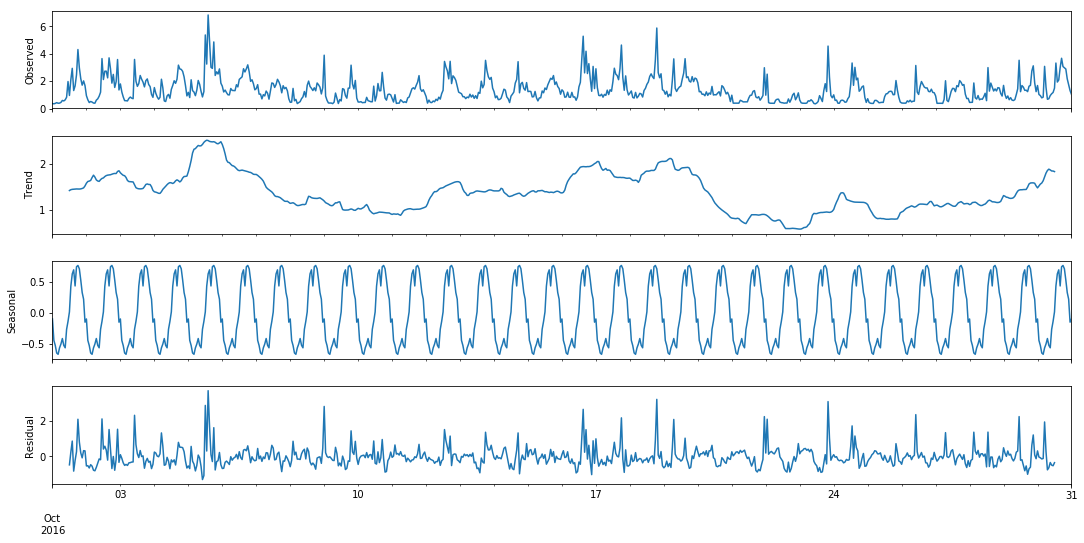

In [7]:
#plot seasonal decomposition
decomposition = seasonal_decompose(df.Hourly_Usage, freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

Test stationarity and perform Dicker-Fuller test

In [8]:
#function to test stationarity
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24)
    rolstd = pd.rolling_std(timeseries, window=24)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=24).mean()
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=24).std()
  


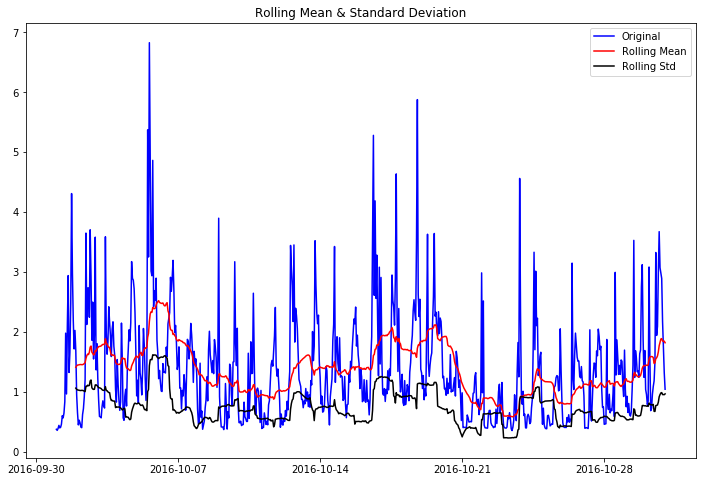

Results of Dickey-Fuller Test:
Test Statistic             -2.758897
p-value                     0.064389
#Lags Used                 20.000000
Number of Observations    700.000000
Critical Value (5%)        -2.865678
Critical Value (1%)        -3.439726
Critical Value (10%)       -2.568973
dtype: float64


In [9]:
test_stationarity(df.Hourly_Usage)

In [10]:
df['first_difference'] = df.Hourly_Usage - df.Hourly_Usage.shift(1)
# test_stationarity(df.first_difference)

In [11]:
df['seasonal_difference'] = df.Hourly_Usage - df.Hourly_Usage.shift(24)
# test_stationarity(df.seasonal_difference)

In [12]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(24)
# test_stationarity(df.seasonal_first_difference)

PACF and ACF charts

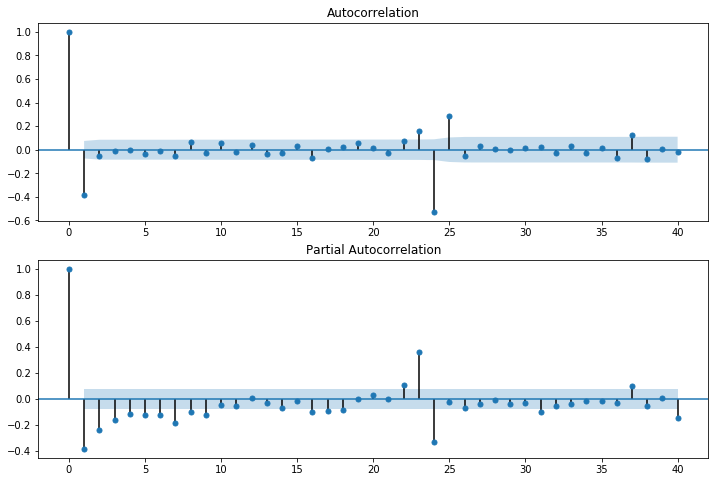

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[25:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[25:], lags=40, ax=ax2)

### Optimize order and seasonal order parameters in SARIMAX model

In [14]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [15]:
#function to find optimal parameters and resulting AIC score
def gridsearch_arima(y, exog=None):

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    low_aic = [0,0,50000]

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y,
                                                  exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < low_aic[2]:
                    low_aic = [param, param_seasonal, results.aic]

#                 print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return low_aic

In [16]:
#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test):

    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]

    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,24)] #test set will always have 24 hours
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])

    return df_train, df_test

In [17]:
# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [18]:
#function to forecast with fitted model, returns MSE and RMSE
def add_forecast(model, test, train, start_time, end_time):

    train['forecast'] = model.predict(start=start_time, end=end_time)
    y_true = test.loc[start_time:end_time, 'Hourly_Usage']
    y_pred = train.loc[start_time:end_time, 'forecast']
    train.loc[start_time:end_time, 'Hourly_Usage'] = test.loc[start_time:end_time, 'Hourly_Usage']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return mse, rmse

In [19]:
def plot_forecast(data, datapoints):
    fig = plt.figure(figsize=(16,8))
    plt.plot(data['Hourly_Usage'][datapoints:])
    plt.plot(data['forecast'])
    plt.legend()

In [20]:
#function to start/end dates for train and test
def find_dates(building_id, final_date=None):
    start_train, end_test = find_egauge_dates(building_id)
    time_delta_1 = timedelta(days=1)
    time_delta_2 = timedelta(hours=1)
    end_train = end_test - time_delta_1
    start_test = end_train + time_delta_2
    start_train = str(start_train)
    end_train = str(end_train)
    start_test = str(start_test)
    end_test = str(end_test)
    
    return start_train, end_train, start_test, end_test

In [96]:
def fit_arima(data, building_id):
    
    start_train, end_train, start_test, end_test = find_dates(building_id)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test)
    
    y_train = df_train.Hourly_Usage
    low_aic = gridsearch_arima(y_train)
    
    arima = sm.tsa.statespace.SARIMAX(y_train,
                                  trend=None,
                                  order=low_aic[0],
                                  seasonal_order=low_aic[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = arima.fit()
    
    return results

In [97]:
arima_results = fit_arima(df, 4874)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [100]:
arima_results.params

ar.L1       0.851799
ma.L1      -0.493442
ma.S.L24   -0.912977
sigma2      0.373973
dtype: float64

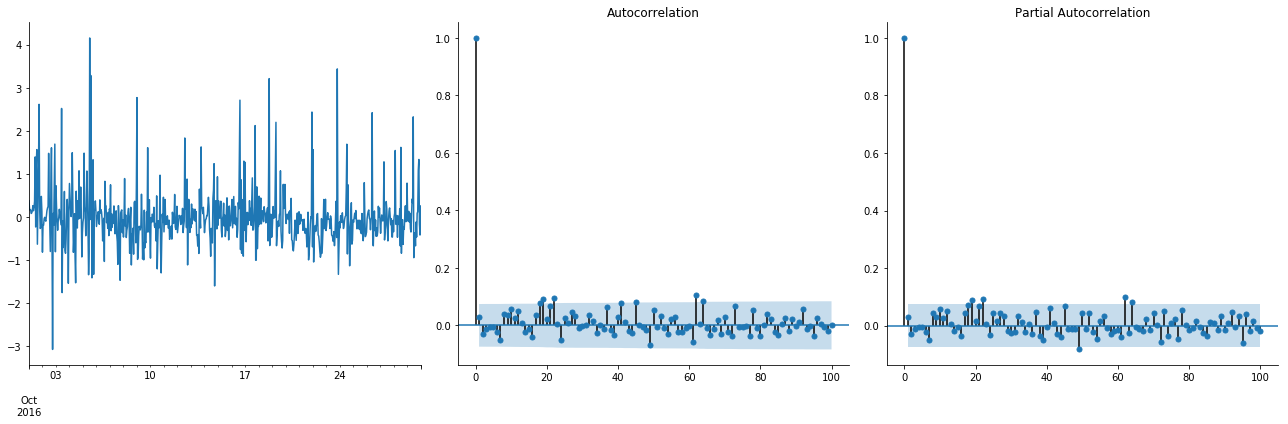

In [101]:
acf_pacf_plots(arima_results.resid.dropna(), lags=100)

(0.70747995342206416, 0.84111827552494911)


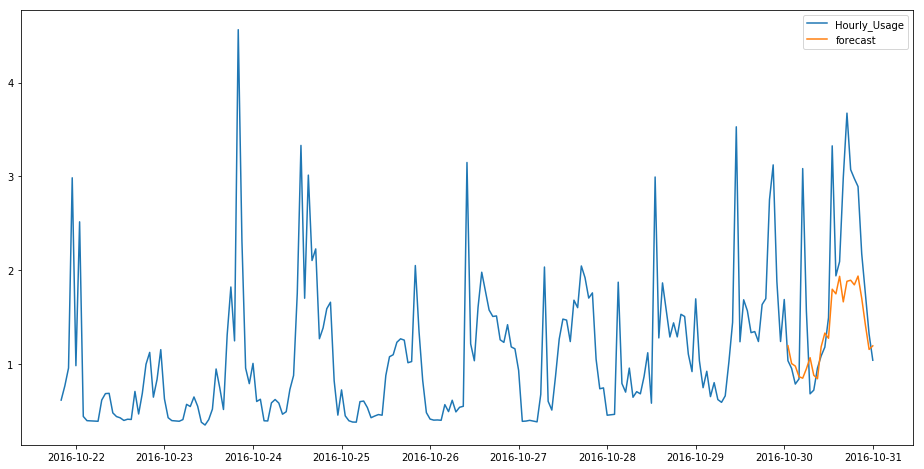

In [102]:
print(add_forecast(arima_results, df_test, df_train, start_test,end_test))
plot_forecast(df_train, 500)

### Add exogenous variables to SARIMAX model

Ideas: day of week (weekend), weather

In [103]:
#function to add all exogenous variables
def add_exog(data, weather, start_time, end_time):

    #add dummy variables for precipitation
    precip = pd.get_dummies(weather.precip_type)
    data = data.join(precip)
    
    data['Day_of_Week'] = data.index.dayofweek
    data['Weekend'] = data.apply(is_weekend, axis=1)
    data['Temperature'] = weather.loc[start_time:end_time, 'temperature']
    data['Humidity'] = weather.loc[start_time:end_time, 'humidity']
    data['Precip_Intensity'] = weather.loc[start_time:end_time, 'precip_intensity']
    data.rename(columns={'rain':'Rain', 'sleet':'Sleet', 'snow':'Snow'}, inplace=True)
    
    #fill missing values with mean
    data['Temperature'] = data.Temperature.fillna(np.mean(data['Temperature']))
    data['Humidity'] = data.Humidity.fillna(np.mean(data['Humidity']))
    data['Precip_Intensity'] = data.Precip_Intensity.fillna(np.mean(data['Precip_Intensity']))
    

    
    return data

In [107]:
def fit_exog_arima(data, weather, building_id):
    
    start_train, end_train, start_test, end_test = find_dates(building_id)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test)
    df_exog = add_exog(df_train, weather, start_train, end_test)
    
    exogenous = df_exog.loc[start_train:,['Weekend','Temperature','Humidity']].astype(float)
    endogenous = df_exog.loc[:,'Hourly_Usage'].astype(float)
    
    low_aic = gridsearch_arima(endogenous,exogenous)
    arima = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=low_aic[0],
                                  seasonal_order=low_aic[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = arima.fit()
    
    return df_exog, results

In [109]:
def plot_exog_arima(data, building_id):
    
    start_train, end_train, start_test, end_test = find_dates(building_id)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test)
    
    mse, rmse = add_forecast(results_2, df_exog_test, df_exog_train, start_test, end_test)
    plot_forecast(df_exog_train, 500)
    
    return mse, rmse

In [110]:
df_exog, arima_exog_results = fit_exog_arima(df, df_weather_austin, 4874)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

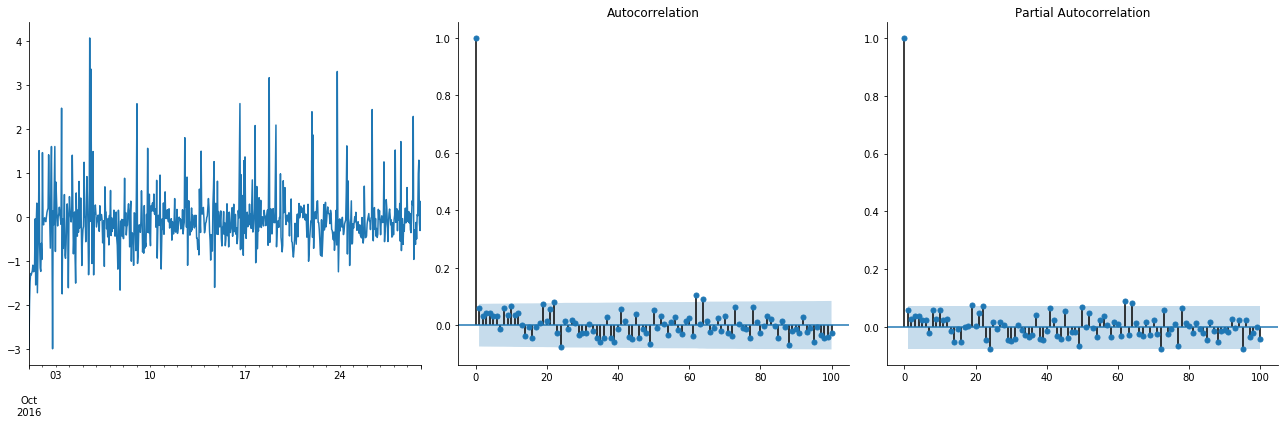

In [111]:
acf_pacf_plots(arima_exog_results.resid.dropna(), lags=100)

In [112]:
arima_results.aic, arima_exog_results.aic

(1236.1592943463777, 1217.5524814235239)

Worse AIC score but let's see if the MSE is better

(0.48241253980875815, 0.69455924139612324)

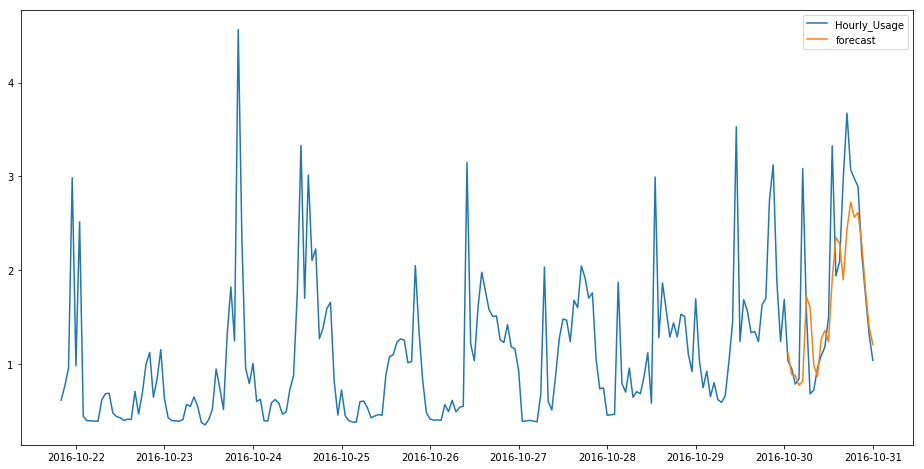

In [113]:
plot_exog_arima(df_exog, 4874)

## Baseline model scores (AR and MA)

AR

In [114]:
#function to plot AR forecast and MSE
def ar_scores(data, building_id, p):
    
    start_train, end_train, start_test, end_test = find_dates(building_id)
    df_baseline_train, df_baseline_test = create_train_test(data, start_train, end_train, start_test, end_test)
    df_baseline_train.loc[start_test:,'Hourly_Usage'] = np.nan
    ar_baseline = sm.tsa.statespace.SARIMAX(endog=df_baseline_train.Hourly_Usage,
                                  trend=None,
                                  order=(p, 0, 0),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = ar_baseline.fit()
    mse, rmse = add_forecast(results, df_baseline_test, df_baseline_train, start_test, end_test)
    plot_forecast(df_baseline_train, 500)
    
    return mse, rmse

(0.75908081012785333, 0.87125243765963334)

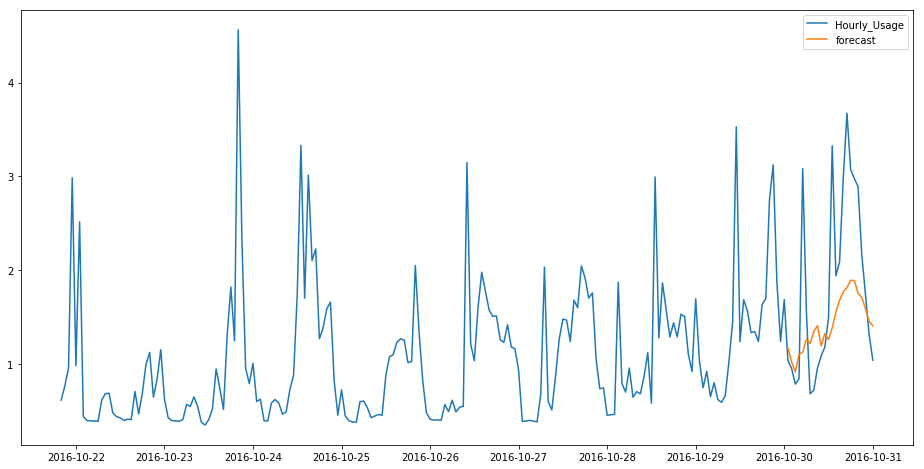

In [115]:
ar_scores(df, 4874, 24)

MA

In [116]:
#function to plot AR forecast and MSE
def ma_scores(data, building_id, q):
    
    start_train, end_train, start_test, end_test = find_dates(building_id)
    df_baseline_train, df_baseline_test = create_train_test(data, start_train, end_train, start_test, end_test)
    df_baseline_train.loc[start_test:,'Hourly_Usage'] = np.nan
    ar_baseline = sm.tsa.statespace.SARIMAX(endog=df_baseline_train.Hourly_Usage,
                                  trend=None,
                                  order=(0, 0, q),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = ar_baseline.fit()
    mse, rmse = add_forecast(results, df_baseline_test, df_baseline_train, start_test, end_test)
    plot_forecast(df_baseline_train, 500)
    
    return mse, rmse

(3.6093230221182218, 1.8998218395729167)

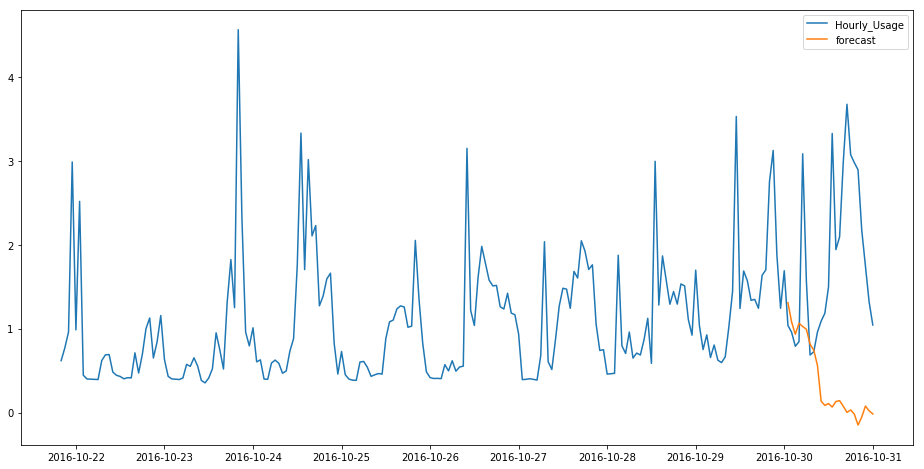

In [117]:
ma_scores(df, 4874, 24)